***Clustering Pipeline Bert***

Imports

In [37]:
from datasets import load_dataset, concatenate_datasets
import torch
import numpy as np
from tqdm.auto import tqdm


Load Model + Tokenizer

In [38]:
model_path = "./bert-finetuned"
from transformers import (BertTokenizerFast,BertForSequenceClassification)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

Load Dataset

In [39]:
# Load dataset
dataset = load_dataset('imdb')
train_data = dataset["train"]
test_data = dataset["test"]


In [40]:
# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# move to device
model.to(device)

#eval mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
# Dictionary to store the embeddings output for the last forward pass
embedding_info = {"output": None}

def embeddings_hook(module, input_, output):
    """
    This function is called automatically during the forward pass.
    `output` is the embedding tensor we care about.
    """
    embedding_info["output"] = output
    # We need gradients w.r.t. this output
    output.retain_grad()

# Register the hook on the embeddings module of BERT
hook_handle = model.bert.embeddings.register_forward_hook(embeddings_hook)


In [42]:
model_path = "./bert-finetuned"
from transformers import (BertTokenizerFast,BertForSequenceClassification)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [43]:
# Load dataset
dataset = load_dataset('imdb')
train_data = dataset["train"]
test_data = dataset["test"]


In [44]:
# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# move to device
model.to(device)

#eval mode
model.eval()

vocab_size = tokenizer.vocab_size
special_token_ids = {
    tokenizer.cls_token_id,
    tokenizer.sep_token_id,
    tokenizer.pad_token_id
}
max_length = 500 # adjust maybe necessary 256

In [45]:
def grad_l2_salience_one(model, tokenizer, text, device, max_length=256, target_label=None):
    """
    Returns:
      pred_label: int
      token_ids: List[int]
      tokens:    List[str]
      salience:  1D torch tensor [seq_len] (on CPU)
    """
    model.eval()

    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)         # [1, L]
    attention_mask = enc["attention_mask"].to(device)

    # Build embeddings and keep grad
    embedding_layer = model.bert.embeddings.word_embeddings
    embedded = embedding_layer(input_ids)           # [1, L, d]
    embedded.retain_grad()

    # Forward through encoder + classifier
    outputs_bert = model.bert(
        inputs_embeds=embedded,
        attention_mask=attention_mask,
        return_dict=True
    )
    pooled_output = outputs_bert.pooler_output     # [1, d]
    logits = model.classifier(pooled_output)       # [1, num_labels]

    pred_label = logits.argmax(dim=-1).item()
    if target_label is None:
        target_label = pred_label

    target_logit = logits[0, target_label]

    # Backprop to embeddings
    model.zero_grad()
    target_logit.backward()

    grads = embedded.grad[0]                       # [L, d]
    salience = grads.norm(p=2, dim=-1).detach().cpu()  # [L]

    token_ids = input_ids[0].detach().cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    return pred_label, token_ids, tokens, salience


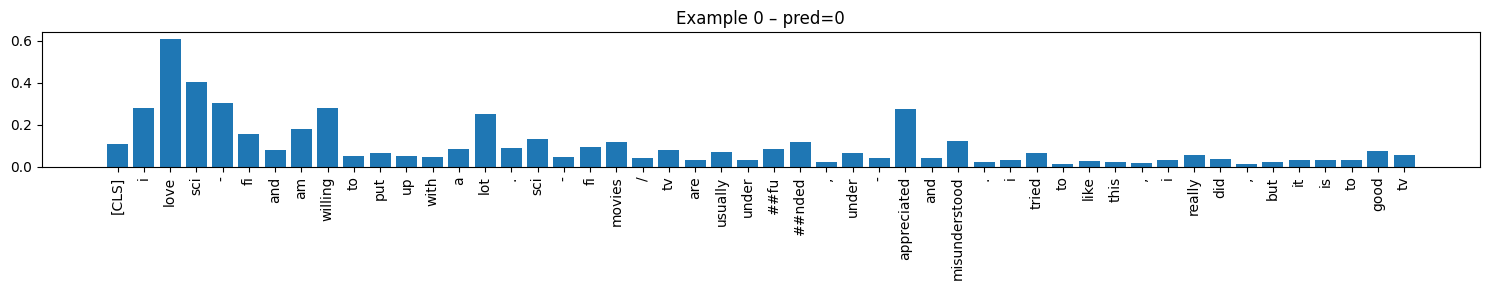

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_salience(tokens, salience, title=None, max_tokens=50):
    tokens = tokens[:max_tokens]
    sal = salience[:max_tokens]

    x = np.arange(len(tokens))
    plt.figure(figsize=(max(8, len(tokens) * 0.3), 3))
    plt.bar(x, sal)
    plt.xticks(x, tokens, rotation=90)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Example
example_text = test_data[0]["text"]
pred, ids, toks, sal = grad_l2_salience_one(model, tokenizer, example_text, device, max_length=max_length)
plot_token_salience(toks, sal, title=f"Example 0 – pred={pred}")


In [50]:
def build_vocab_representation(token_ids, salience, vocab_size, special_token_ids=None, k_top=5):
    """
    token_ids: list[int]
    salience:  1D tensor or array [seq_len]
    Returns:
      r_vocab: np.array [vocab_size], with only up to k_top tokens nonzero
    """
    if special_token_ids is None:
        special_token_ids = set()

    salience = np.abs(np.array(salience, dtype=np.float32))
    r = np.zeros(vocab_size, dtype=np.float32)

    for tid, s in zip(token_ids, salience):
        if tid in special_token_ids:
            continue
        if s > r[tid]:
            r[tid] = s

    # keep only top-k entries
    if k_top is not None and k_top < vocab_size:
        if (r > 0).sum() > k_top:
            top_idx = np.argpartition(r, -k_top)[-k_top:]
            mask = np.zeros_like(r, dtype=bool)
            mask[top_idx] = True
            r[~mask] = 0.0
    return r


In [51]:
num_target = 2500          # you can change this
target_pred_label = 0      # IMDB: 0 = negative, 1 = positive

rows_vocab = []
texts_subset = []
gold_labels_subset = []
pred_labels_subset = []
indices_subset = []

for idx in tqdm(range(len(test_data))):
    example = test_data[idx]
    text = example["text"]
    gold = int(example["label"])

    pred, token_ids, tokens, salience = grad_l2_salience_one(
        model, tokenizer, text, device, max_length=max_length
    )

    if pred != target_pred_label:
        continue

    r_vocab = build_vocab_representation(
        token_ids, salience,
        vocab_size=vocab_size,
        special_token_ids=special_token_ids,
        k_top=5
    )

    rows_vocab.append(r_vocab)
    texts_subset.append(text)
    gold_labels_subset.append(gold)
    pred_labels_subset.append(pred)
    indices_subset.append(idx)

    if len(rows_vocab) >= num_target:
        break

len(rows_vocab), len(texts_subset)


  0%|          | 0/25000 [00:00<?, ?it/s]/var/folders/l5/3zb8ns612s38jb5qz423_rvr0000gn/T/ipykernel_2268/4095474408.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  salience = np.abs(np.array(salience, dtype=np.float32))
 11%|█▏        | 2852/25000 [03:12<24:55, 14.81it/s]


(2500, 2500)

In [53]:
R_vocab = np.stack(rows_vocab, axis=0)                  # [N, V]
norms = np.linalg.norm(R_vocab, axis=1, keepdims=True) + 1e-8
R_vocab = R_vocab / norms
R_vocab.shape

(2500, 30522)

In [54]:
with torch.no_grad():
    E = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()  # [V, d]

R_emb = R_vocab @ E                     # [N, d]
norms_emb = np.linalg.norm(R_emb, axis=1, keepdims=True) + 1e-8
R_emb = R_emb / norms_emb
R_emb.shape


(2500, 768)

In [56]:
from sklearn.cluster import KMeans

n_clusters = 5   # adjust
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_ids = kmeans.fit_predict(R_emb)
cluster_ids[:20]


array([0, 4, 1, 3, 0, 4, 1, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 0, 1, 1],
      dtype=int32)

In [57]:
def plot_cluster_top_tokens(R_vocab, cluster_ids, cluster_idx, tokenizer, k=20):
    mask = (cluster_ids == cluster_idx)
    R_c = R_vocab[mask]
    mean_salience = R_c.mean(axis=0)              # [V]

    top_idx = np.argsort(mean_salience)[-k:][::-1]
    toks = [tokenizer.convert_ids_to_tokens(int(i)) for i in top_idx]
    vals = [mean_salience[i] for i in top_idx]

    plt.figure(figsize=(8, 4))
    x = np.arange(k)
    plt.bar(x, vals)
    plt.xticks(x, toks, rotation=90)
    plt.title(f"Cluster {cluster_idx} – top {k} tokens (Grad-L2 salience)")
    plt.tight_layout()
    plt.show()


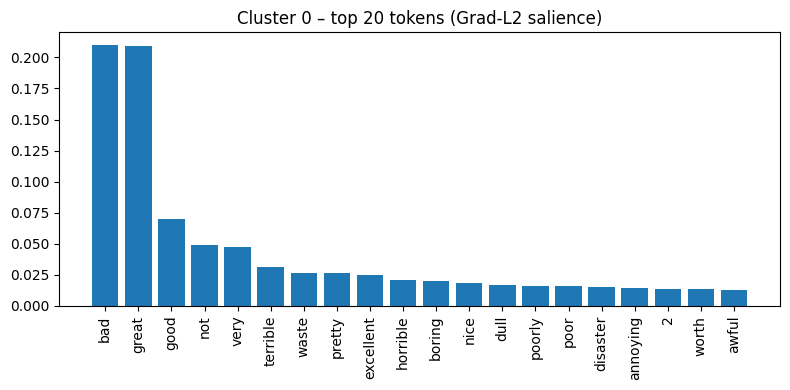

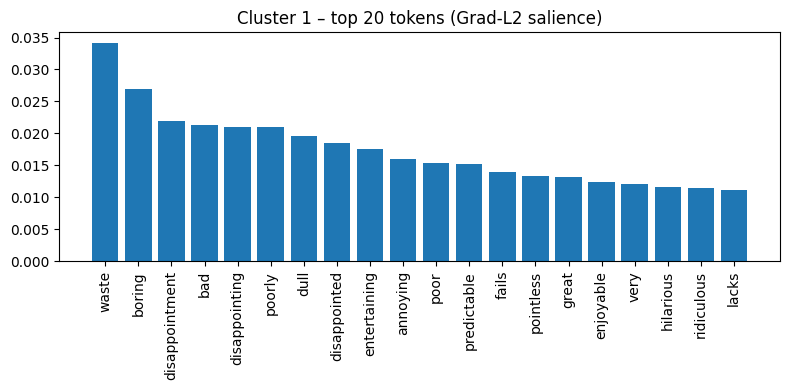

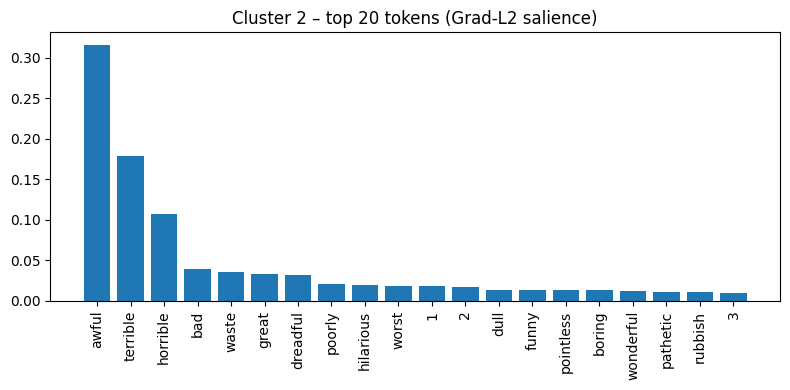

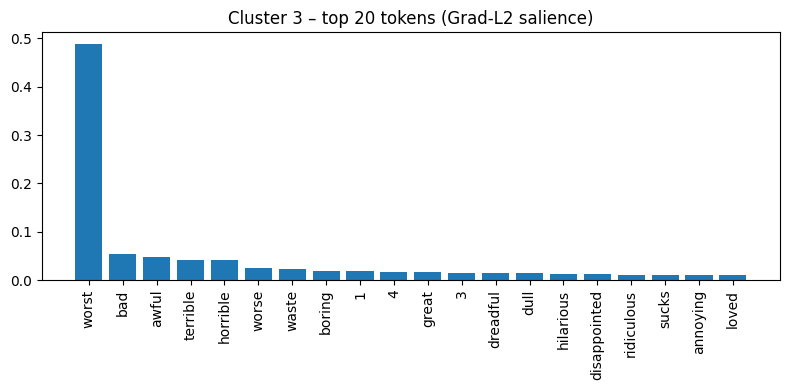

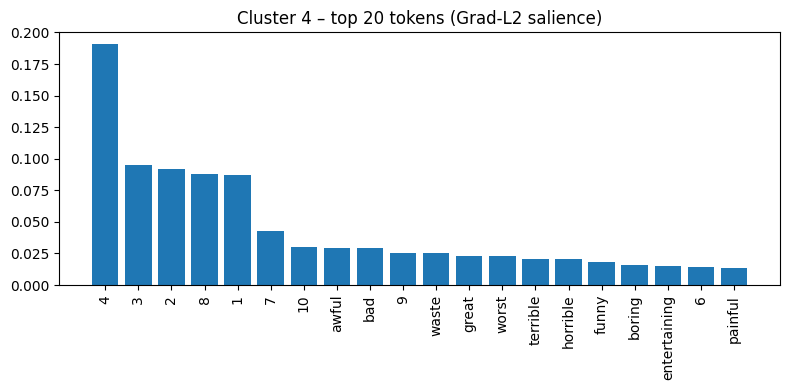

In [58]:
for c in range(n_clusters):
    plot_cluster_top_tokens(R_vocab, cluster_ids, c, tokenizer, k=20)


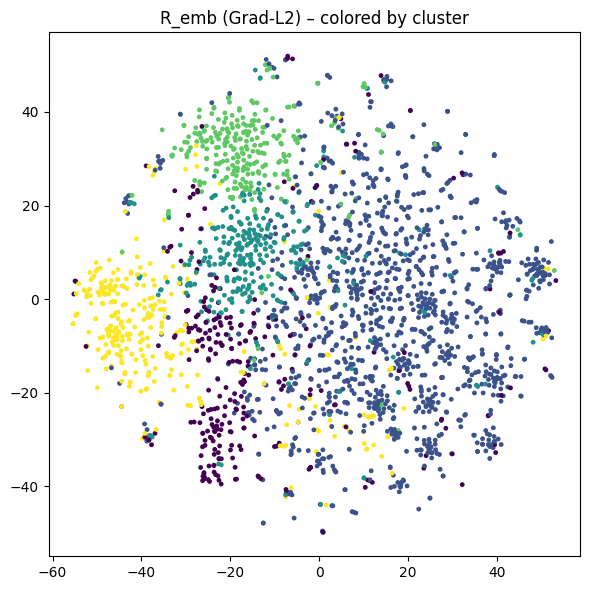

In [59]:
from sklearn.manifold import TSNE

def plot_tsne(X, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=6)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_tsne(R_emb, cluster_ids, title="R_emb (Grad-L2) – colored by cluster")
